<a href="https://colab.research.google.com/github/yasminemejrissi/dashbord-ecommerce/blob/main/projet1_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install faker
!pip install pymongo
!pip install matplotlib
!pip install pandas
!pip install streamlit

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from faker import Faker
import datetime
import streamlit as st
from config import uri_mongo

from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

client = MongoClient(uri_mongo, server_api=ServerApi('1'))

In [3]:
fake=Faker()
client=MongoClient(uri_mongo, server_api=ServerApi('1'))
db=client["ecommerce"]
clients_col=db["clients"]
commandes_col=db["commandes"]

In [4]:
#on nettoie tout
clients_col.delete_many({})
commandes_col.delete_many({})

DeleteResult({'n': 11126, 'electionId': ObjectId('7fffffff0000000000000038'), 'opTime': {'ts': Timestamp(1745161020, 172), 't': 56}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1745161020, 172), 'signature': {'hash': b'@\x87\xca\xeat8[K\xc0f\xb3P \xa9\xf6\x91\xa8\xbc\x04\xbd', 'keyId': 7464295776219299841}}, 'operationTime': Timestamp(1745161020, 172)}, acknowledged=True)

In [5]:
#Générer les produits
produits=[
    {"nom":"T-shirt","catégorie":"Vêtements","prix":20},
    {"nom":"Jean","catégorie":"Vêtements","prix":45},
    {"nom":"Basket","catégorie":"Chaussures","prix":70},
    {"nom":"Bracelet","catégorie":"Accessoires","prix":18},
    {"nom":"Collier","catégorie":"Accessoires","prix":25},
    {"nom":"Sac à main", "catégorie":"Bagagerie", "prix":20},
    {"nom":"Sac à dos", "catégorie":"Bagagerie", "prix":30},
    {"nom":"Montre", "catégorie":"Accessoires", "prix":90},
    {"nom":"Full Korean skincare", "catégorie":"Beauté", "prix":120},
    {"nom":"Chargeur", "catégorie":"Informatique","prix":15},

]

In [6]:
#Générer les clients et les commandes:
clients=[]
for i in range(100):
  client={
      "nom":fake.last_name(),
      "prenom":fake.first_name(),
      "email":fake.email(),
      "adresse":fake.address(),
      "code_postal":fake.zipcode(),
      "ville":fake.city(),
      "pays":fake.country()}

  client_id=clients_col.insert_one(client).inserted_id #créer un id unique pour chaque client
  clients.append({"_id":client_id, **client}) #ajouter l'id à chaque client

#pour générer les commandes
commandes = []
mode_paiement=["Carte bancaire","Paypal","Virement","Apple Pay"]
code_promo_possible=[None,"WELCOME10","SALES20",F"FREESHIP"]

for i in range(2000):
  client=random.choice(clients)
  nb_produits=random.randint(1,len(produits))

  produit_commande=[]
  montant_total=0
  for j in range(nb_produits):
    produit=random.choice(produits)
    quantite=random.randint(1,5)
    prix=produit["prix"]
    montant=round(prix*quantite,2)
    produit_commande.append({
        "nom":produit["nom"],
        "prix_unitaire":prix,
        "quantite":quantite,
        "montant":montant,
        })
    montant_total+=montant
    date=fake.date_between(start_date="-6M", end_date="today")
    commande={
        "client_id":client["_id"],
        "produits":produit_commande,
        "montant":montant_total,
        "date":date.isoformat(),
        "mode_paiement":random.choice(mode_paiement),
        "code_promo":random.choice(code_promo_possible),
        "adresse":client["adresse"],
        "ville":client["ville"],
        "pays":client["pays"],
        "email":client["email"]
    }
    commandes.append(commande)

commandes_col.insert_many(commandes)

for doc in commandes_col.find().limit(3):
  print(doc)

{'_id': ObjectId('68050b4a22fd5b681126741d'), 'client_id': ObjectId('68050b4122fd5b68112673ca'), 'produits': [{'nom': 'Collier', 'prix_unitaire': 25, 'quantite': 2, 'montant': 50}, {'nom': 'Sac à main', 'prix_unitaire': 20, 'quantite': 2, 'montant': 40}, {'nom': 'Montre', 'prix_unitaire': 90, 'quantite': 2, 'montant': 180}, {'nom': 'Montre', 'prix_unitaire': 90, 'quantite': 1, 'montant': 90}, {'nom': 'Sac à main', 'prix_unitaire': 20, 'quantite': 1, 'montant': 20}, {'nom': 'Chargeur', 'prix_unitaire': 15, 'quantite': 4, 'montant': 60}], 'montant': 50, 'date': '2025-04-17', 'mode_paiement': 'Paypal', 'code_promo': None, 'adresse': '35955 Wilkinson Crossroad\nRobertville, NJ 79586', 'ville': 'Coxchester', 'pays': 'Lebanon', 'email': 'amber57@example.net'}
{'_id': ObjectId('68050b4a22fd5b681126741e'), 'client_id': ObjectId('68050b4122fd5b68112673ca'), 'produits': [{'nom': 'Collier', 'prix_unitaire': 25, 'quantite': 2, 'montant': 50}, {'nom': 'Sac à main', 'prix_unitaire': 20, 'quantite': 

In [7]:
#regrouper par pays
pipeline=[
    {
        "$group":{
            "_id":"$pays",
            "chiffre_affaires":{"$sum":"$montant"},
            "nb_commandes":{"$sum":1}
        }
    },
    {

          "$sort":{"chiffre_affaires":-1}

    }
]
resultat=list(commandes_col.aggregate(pipeline))
for doc in commandes_col.find().limit(5):
  print(doc["pays"])
for doc in resultat:
  if doc['chiffre_affaires'] is not None:
    print(f"{doc['_id']}:{doc['chiffre_affaires']}€ sur {doc['nb_commandes']} commandes")
  else:
    print(f"{doc['_id']}: Aucun chiffre d'affaires")

Lebanon
Lebanon
Lebanon
Lebanon
Lebanon
Tokelau:194331€ sur 336 commandes
Antigua and Barbuda:162503€ sur 301 commandes
Philippines:148328€ sur 282 commandes
Swaziland:142097€ sur 237 commandes
Mexico:139040€ sur 249 commandes
Switzerland:135542€ sur 250 commandes
Equatorial Guinea:135112€ sur 270 commandes
Mongolia:135084€ sur 249 commandes
Honduras:128361€ sur 246 commandes
Greenland:123618€ sur 201 commandes
Sierra Leone:123388€ sur 175 commandes
Faroe Islands:115398€ sur 209 commandes
South Africa:115130€ sur 187 commandes
Bhutan:113502€ sur 235 commandes
Korea:112291€ sur 165 commandes
Czech Republic:108408€ sur 220 commandes
Sri Lanka:107098€ sur 221 commandes
Mauritius:101963€ sur 189 commandes
Anguilla:99809€ sur 149 commandes
Gibraltar:99524€ sur 193 commandes
Mozambique:96706€ sur 204 commandes
Comoros:93327€ sur 184 commandes
Somalia:90682€ sur 178 commandes
Indonesia:90609€ sur 176 commandes
Malta:84176€ sur 148 commandes
Singapore:81994€ sur 174 commandes
Palestinian Terri

Tokelau : 194331 € sur 336 commandes
Antigua and Barbuda : 162503 € sur 301 commandes
Philippines : 148328 € sur 282 commandes
Swaziland : 142097 € sur 237 commandes
Mexico : 139040 € sur 249 commandes
Switzerland : 135542 € sur 250 commandes
Equatorial Guinea : 135112 € sur 270 commandes
Mongolia : 135084 € sur 249 commandes
Honduras : 128361 € sur 246 commandes
Greenland : 123618 € sur 201 commandes
Sierra Leone : 123388 € sur 175 commandes
Faroe Islands : 115398 € sur 209 commandes
South Africa : 115130 € sur 187 commandes
Bhutan : 113502 € sur 235 commandes
Korea : 112291 € sur 165 commandes
Czech Republic : 108408 € sur 220 commandes
Sri Lanka : 107098 € sur 221 commandes
Mauritius : 101963 € sur 189 commandes
Anguilla : 99809 € sur 149 commandes
Gibraltar : 99524 € sur 193 commandes
Mozambique : 96706 € sur 204 commandes
Comoros : 93327 € sur 184 commandes
Somalia : 90682 € sur 178 commandes
Indonesia : 90609 € sur 176 commandes
Malta : 84176 € sur 148 commandes
Singapore : 81994

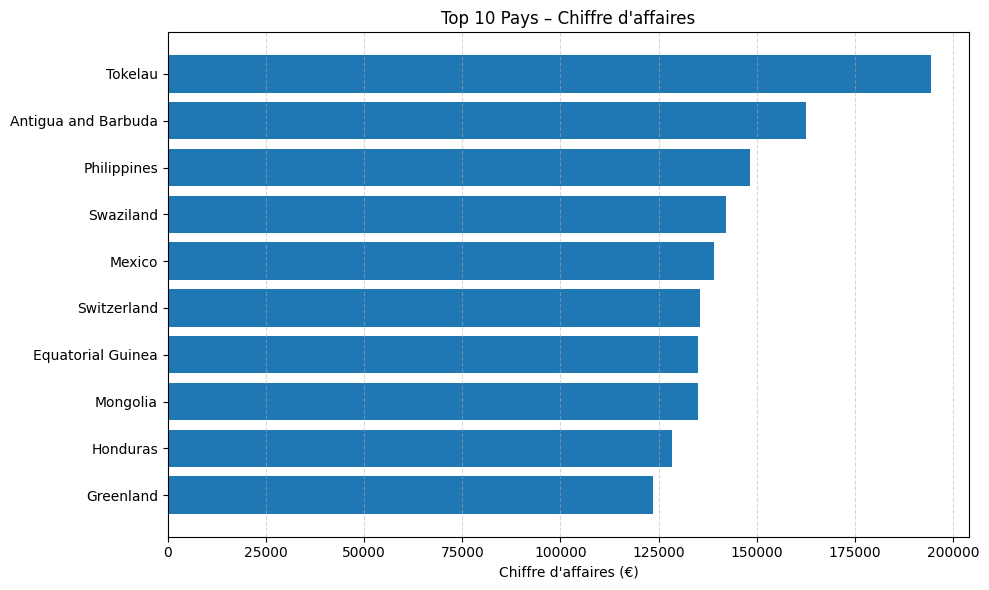

In [8]:
#Agrégation MongoDB – KPI Chiffre d'affaires par pays
pipeline = [
    {
        "$group": {
            "_id": "$pays",
            "chiffre_affaires": { "$sum": "$montant" },
            "nb_commandes": { "$sum": 1 }
        }
    },
    {
        "$sort": { "chiffre_affaires": -1 }
    }
]

resultat = list(commandes_col.aggregate(pipeline))

#Affichage texte
for doc in resultat:
    print(f"{doc['_id']} : {round(doc['chiffre_affaires'], 2)} € sur {doc['nb_commandes']} commandes")

#Visualisation matplotlib
pays = [doc["_id"] for doc in resultat[:10]]
ca = [doc["chiffre_affaires"] for doc in resultat[:10]]

plt.figure(figsize=(10,6))
plt.barh(pays[::-1], ca[::-1])  # pays dans l'ordre du plus petit au plus gros
plt.xlabel("Chiffre d'affaires (€)")
plt.title("Top 10 Pays – Chiffre d'affaires")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
#TOP 10 meilleur client (qui ont le plus dépensé)

pipeline=[
    {
        "$group":{
            "_id":"$client_id",
            "montant_total":{"$sum":"$montant"},
            "nb_commandes":{"$sum":1}
        }
    },
    {
        "$sort":{"montant_total":-1}
    },
    {"$limit":10},
    {
        "$lookup":{
            "from":"clients", #2e collection
            "localField":"_id", #dans notre collection actuelle
            "foreignField":"_id", #celui de l'autre collection: clients
            "as":"client" #on stocke ça dans un nouveau champs clients, qui va retourner un nv tableau avec 1 élément comprenant nom, adresse mail, pays
    }},
    {"$unwind":"$client"},
    {"$project":{
        "nom":"$client.nom",
        "prenom":"$client.prenom",
        "email": "$client.email",
        "adresse":"$client.adresse",
        "ville":"$client.ville",
        "pays":"$client.pays",
        "chiffre_affaires":"$montant_total",
        "nb_commandes":"$nb_commandes"
    }}
]

top_clients=list(commandes_col.aggregate(pipeline))
for client in top_clients:
  print(f"{client['nom']} {client['prenom']} ({client['email']}) - {client['adresse']}, {client['ville']}, {client['pays']} - {round(client['chiffre_affaires'],2)} EUR sur {client['nb_commandes']} commandes.")


Larson Angela (toddboyle@example.net) - 06087 Todd Station Apt. 446
South Christopher, FM 05951, Brittneyborough, Sierra Leone - 123388 EUR sur 175 commandes.
Farmer Chelsea (caseybonilla@example.com) - Unit 2657 Box 2478
DPO AE 82751, New Markchester, Tokelau - 117721 EUR sur 201 commandes.
James Sarah (burkechristopher@example.com) - 6188 Armstrong Ranch Suite 504
Jamesburgh, IN 37242, Port Carrie, South Africa - 115130 EUR sur 187 commandes.
Wheeler Andrea (suarezjohnny@example.com) - 62657 Duncan Camp Suite 484
Port Robert, MO 26992, East Zacharytown, Korea - 112291 EUR sur 165 commandes.
Kelley Cindy (davidhamilton@example.com) - 4057 May Landing
East Christopherfort, NV 82721, New Patricia, Anguilla - 99809 EUR sur 149 commandes.
Brown Elizabeth (douglas61@example.org) - 873 Steve Views
Stevenview, CA 56636, Port Marissaville, Switzerland - 97131 EUR sur 169 commandes.
Young Kristina (sandrajordan@example.org) - 2298 Richard Flats
Scottfort, OR 27251, South Juliehaven, Mexico - 8

In [10]:
#panier moyen
pipeline=[
    {
          "$group":{
              "_id":None,
              "total_montant":{"$sum":"$montant"},
              "total_commandes":{"$sum":1}
          }
      },
      {
          "$project":{
              "_id":0,
              "panier_moyen":{"$divide": ["$total_montant","$total_commandes"]
              },
              "total_montant":1,
              "total_commandes":1
          }
      }
]

resultat= list(commandes_col.aggregate(pipeline))[0]
print(f"Le panier moyen est : {round(resultat['panier_moyen'],2)} EUR")

Le panier moyen est : 531.75 EUR


2024-10 : 812 commandes - 427800 EUR - panier moyen 526.85
2024-11 : 1822 commandes - 948750 EUR - panier moyen 520.72
2024-12 : 1829 commandes - 933573 EUR - panier moyen 510.43
2025-01 : 1958 commandes - 1054093 EUR - panier moyen 538.35
2025-02 : 1669 commandes - 925136 EUR - panier moyen 554.31
2025-03 : 1778 commandes - 938713 EUR - panier moyen 527.96
2025-04 : 1174 commandes - 643464 EUR - panier moyen 548.1


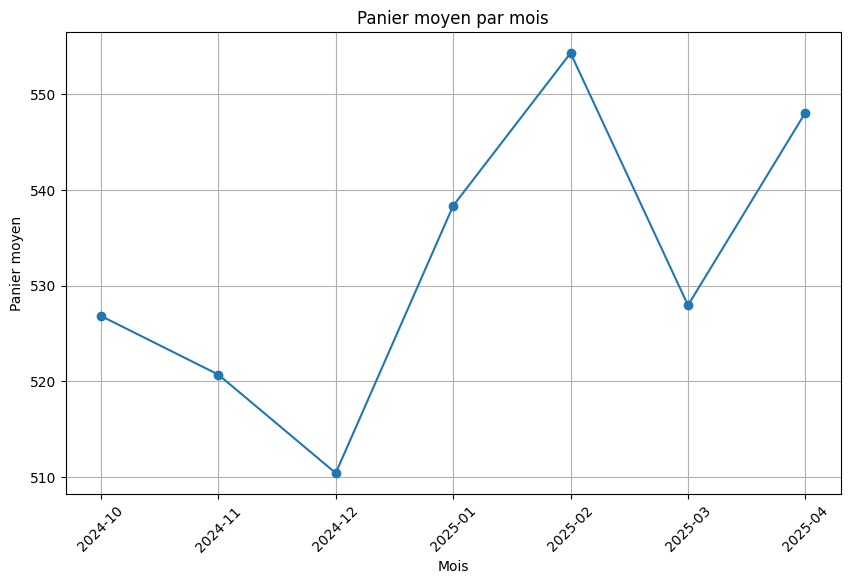

In [11]:
#panier moyen par mois

pipeline=[
    {
        "$group":{
            "_id": {"$substr":["$date",0,7]},
            "nb_commandes": {"$sum":1},
            "chiffre_affaires":{"$sum":"$montant"},
        }
    },
    {
        "$project":{
            "nb_commandes":1,
            "chiffre_affaires":1,
            "panier_moyen":{"$divide":["$chiffre_affaires","$nb_commandes"]}
        }
    },
    {
        "$sort":{"_id":1}
    }
]
resultat=list(commandes_col.aggregate(pipeline))
for ligne in resultat:
  print(f"{ligne['_id']} : {ligne['nb_commandes']} commandes - {round(ligne['chiffre_affaires'],2)} EUR - panier moyen {round(ligne['panier_moyen'],2)}")

#dataframe pour panier moyen et affichage

resultat=list(commandes_col.aggregate(pipeline))
df_panier_mensuel=pd.DataFrame(resultat)
df_panier_mensuel.head()
df_panier_mensuel.rename(columns={"_id":"mois"}, inplace="True")
#affichage Matplotlib
plt.figure(figsize=(10,6))
plt.plot(df_panier_mensuel["mois"], df_panier_mensuel["panier_moyen"],marker='o',linestyle='-')
plt.xlabel("Mois")
plt.ylabel("Panier moyen")
plt.title("Panier moyen par mois")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [12]:
#Segmentation des clients

#Créer une analyse comportementale client complète → à partir de la base e-commerce = profiling client.
#Analyser les comportements d’achat pour :
# Repérer les bons clients
# Comprendre leur façon d’acheter
# Créer des segments intelligents : VIP, promo addict, etc.
# Et plus tard, faire du machine learning ou un dashboard métier



pipeline=[
    {
        "$group":{
            "_id":"$client_id",
            "chiffre_affaires":{"$sum":"$montant"},
            "nb_commandes":{"$sum":1},
            "nb_commandes_promos":{
                "$sum":{
                    "$cond":[{"$ne":["$code_promo",None]},1,0]}} #si le code promo est diff de None alors compte 1 sinon 0
        }
    },
    {
        "$project":{
            "nb_commandes":1,
            "chiffre_affaires":1,
            "code_promo":1,
            "panier_moyen":{"$round":[{"$divide":["$chiffre_affaires","$nb_commandes"]},2]},
            "ratio_code_promos": {"$round":[{"$divide":["$nb_commandes_promos","$nb_commandes"]},2]
        }}
    },
    {
        "$lookup":{
            "from":"clients",
            "localField":"_id",
            "foreignField":"_id",
            "as":"client"
        }
    },
    {
        "$unwind":"$client"
    },
    #Affichage
    {
        "$project":{
            "client_id":"$_id",
            "nom":"$client.nom",
            "prenom":"$client.prenom",
            "pays":"$client.pays",
            "email":"$client.email",
            "chiffre_affaires":1,
            "nb_commandes":1,
            "panier_moyen":1,
            "ratio_code_promos":1
        }
    }
]

resultat=list(commandes_col.aggregate(pipeline))
df_comportement=pd.DataFrame(resultat)
colonnes=["client_id","nom","prenom","pays","email","chiffre_affaires","nb_commandes","panier_moyen","ratio_code_promos"]
df=df_comportement[colonnes]

print(df["chiffre_affaires"].describe())
print(df["nb_commandes"].describe())
print(df["panier_moyen"].describe())
print(df["ratio_code_promos"].describe())


count       100.000000
mean      58715.290000
std       19692.009156
min       19693.000000
25%       44930.500000
50%       53943.500000
75%       70914.250000
max      123388.000000
Name: chiffre_affaires, dtype: float64
count    100.000000
mean     110.420000
std       27.941562
min       55.000000
25%       89.750000
50%      108.000000
75%      129.000000
max      201.000000
Name: nb_commandes, dtype: float64
count    100.000000
mean     525.065200
std       71.317225
min      358.050000
25%      474.375000
50%      523.045000
75%      571.575000
max      705.070000
Name: panier_moyen, dtype: float64
count    100.000000
mean       0.746700
std        0.042261
min        0.620000
25%        0.720000
50%        0.750000
75%        0.780000
max        0.830000
Name: ratio_code_promos, dtype: float64


In [13]:
#Segmentation profil
def profiler(row):
  if row["chiffre_affaires"]>=1000 and row["nb_commandes"]>=130:
    return "VIP"
  if row["ratio_code_promos"]>=0.765 and row["nb_commandes"]>=115:
    return "Promo addict"
  if row["nb_commandes"]>=90:
    return "Régulier"
  else:
    return "Occasionnel"

df["profil"]=df.apply(profiler, axis=1)
df.head(10)

,client_id,nom,prenom,pays,email,chiffre_affaires,nb_commandes,panier_moyen,ratio_code_promos,profil
0,68050b4322fd5b68112673de,Haynes,Darrell,Puerto Rico,erin86@example.org,40599,84,483.32,0.70,Occasionnel
1,68050b4922fd5b6811267416,Parker,John,Jersey,theresacole@example.com,73788,115,641.63,0.70,Régulier
2,68050b4422fd5b68112673e9,Carter,Keith,Sri Lanka,martinezbelinda@example.org,70805,134,528.40,0.77,VIP
3,68050b3f22fd5b68112673be,Obrien,Robert,Nauru,jordanrich@example.org,44374,104,426.67,0.81,Régulier
4,68050b4122fd5b68112673cd,Fuller,Amy,Mongolia,tranbrent@example.net,75885,120,632.38,0.76,Régulier
5,68050b4222fd5b68112673d0,Phelps,Justin,Sweden,qbenitez@example.org,52829,98,539.07,0.72,Régulier
6,68050b3c22fd5b68112673b9,Carey,Devon,Mexico,bmeyer@example.org,52821,115,459.31,0.69,Régulier
7,68050b4222fd5b68112673d5,Robbins,Valerie,Vanuatu,joseph15@example.org,49740,102,487.65,0.74,Régulier
8,68050b4422fd5b68112673e7,Robinson,Anita,Brazil,alopez@example.net,64824,111,584.00,0.77,Régulier
9,68050b3f22fd5b68112673bd,Fox,Denise,Cambodia,joshuagillespie@example.com,49494,106,466.92,0.75,Régulier


<Figure size 640x480 with 0 Axes>

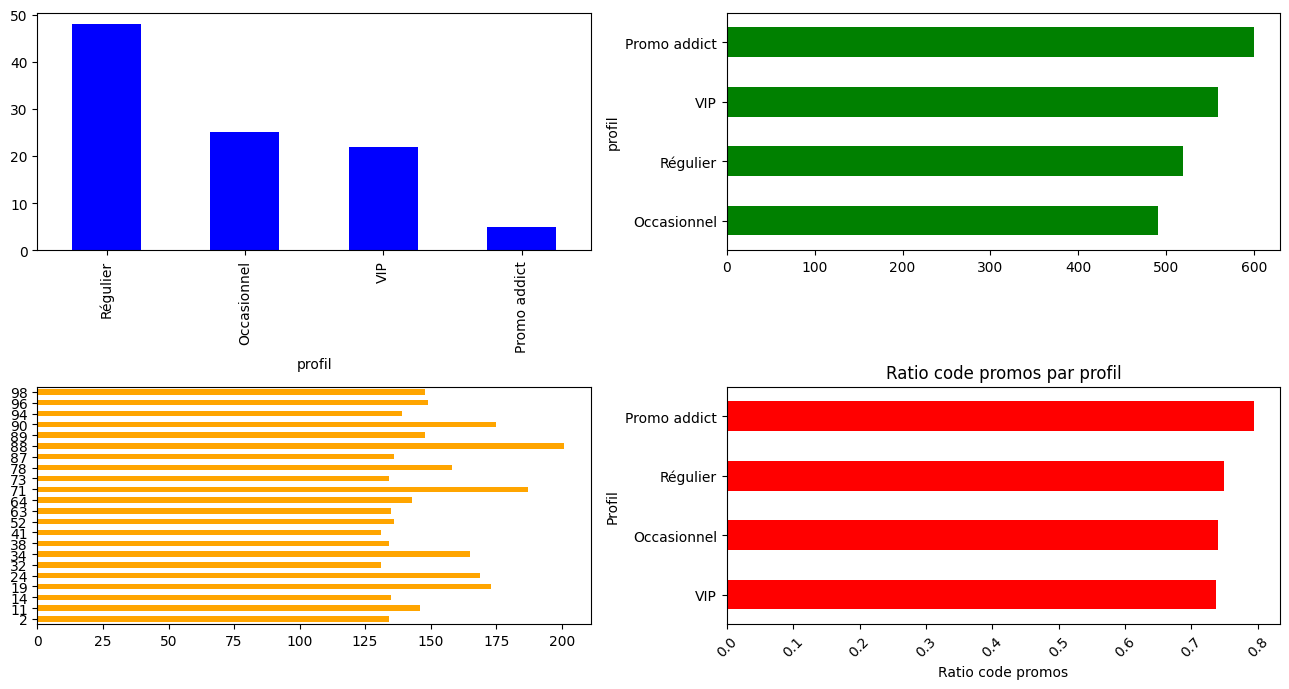

In [14]:
#dashboard avec matplotlib
plt.figure()
fig,axes=plt.subplots(2,2,figsize=(13,7))
df["profil"].value_counts().plot(kind="bar",color="blue",ax=axes[0,0])
plt.title("Nombre de clients par profil")
plt.xlabel("Profil")
plt.ylabel("Nombre de clients")
plt.xticks(rotation=45)
plt.tight_layout()

#panier moyen
df.groupby("profil")["panier_moyen"].mean().sort_values().plot(kind="barh",color="green",ax=axes[0,1])
plt.title("Panier moyen par profil")
plt.xlabel("Panier moyen")
plt.ylabel("Profil")
plt.xticks(rotation=45)
plt.tight_layout()


#nb de commandes par profil
df.groupby("profil")["nb_commandes"].plot(kind="barh",color="orange",ax=axes[1,0])
plt.title("Nombre de commandes par profil")
plt.xlabel("Nombre de commandes")
plt.ylabel("Profil")
plt.xticks(rotation=45)
plt.tight_layout()

#ratios code promos
df.groupby("profil")["ratio_code_promos"].mean().sort_values().plot(kind="barh",color="red",ax=axes[1,1])
plt.title("Ratio code promos par profil")
plt.xlabel("Ratio code promos")
plt.ylabel("Profil")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
#dashboard avec streamlit dans github

In [16]:
df.to_csv("dashboard_clients.csv", index=False)